# Clasificación con conjunto de datos _iris_

[**Juan Gómez Romero**](https://decsai.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

---

### Activar GPU
_Entorno de ejecución > Cambiar tipo de entorno de ejecución_

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Cargar datos de _iris_
Cargamos los datos de [ _iris_](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) incluidos en el paquete [`scikit-learn`](https://scikit-learn.org/).
- features: entrada (150 x 4)
- labels: salida (150 x 1)

In [2]:
from sklearn import datasets
data = datasets.load_iris()

features = data.data[:, :]
labels   = data.target

print(data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Visualizamos los datos. Las clases de _iris_ son fácilmente separables con las variables `petal_length` y `petal_width`.

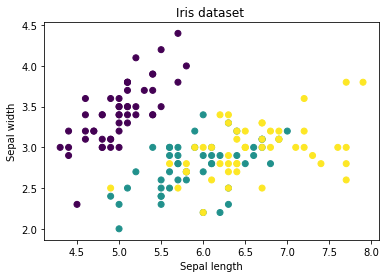

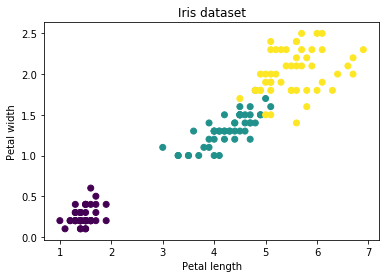

In [3]:
import matplotlib.pyplot as plt
plt.title('Iris dataset ')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.scatter(features[:, 0], features[:, 1], c = labels)
plt.show()

plt.title('Iris dataset')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.scatter(features[:, 2], features[:, 3], c = labels)
plt.show()

## Definir arquitectura
Definimos la arquitectura de la red neuronal:
- Entrada: 4 neuronas
- Oculta: 2 x 16 neuronas (*sigmoid*)
- Salida: 3 neuronas (*softmax*)

<img src="https://github.com/jgromero/eci2019-DRL/blob/master/Tema%202%20-%20Aprendizaje%20Profundo/code/iris-nn.png?raw=true" width="500">

In [4]:
import torch.nn as nn

torch.manual_seed(1)

net = nn.Sequential(
    nn.Linear(in_features = features.shape[1], out_features = 16),
    nn.ReLU(),
    nn.Linear(in_features = 16, out_features = 16),
    nn.ReLU(),
    nn.Linear(in_features = 16, out_features = 3),
    nn.Softmax(dim = 0)
)
net = net.to(device)

net

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=3, bias=True)
  (5): Softmax()
)

Calcular salida para una entrada del conjunto del entrenamiento.

In [5]:
input = torch.tensor(features[0, :], dtype=torch.float32, device=device)
output = net(input)
print("Predicción: " , output)
print("Predicción clase: " , torch.argmax(output))
print("Salida esperada: ", labels[0])

Predicción:  tensor([0.2294, 0.3464, 0.4241], grad_fn=<SoftmaxBackward>)
Predicción clase:  tensor(2)
Salida esperada:  0


## Entrenar red

Preparamos los datos al formato esperado por la red y separamos los conjuntos de entrenamiento y test.

In [6]:
import torch.utils.data

x_dataset = torch.tensor(features, dtype = torch.float32)
y_dataset = torch.tensor(labels, dtype = torch.long)
dataset   = torch.utils.data.TensorDataset(x_dataset, y_dataset)

perc_split = 0.8
n_train = round(perc_split * len(features))
n_val   = len(features) - n_train
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

Definimos la función de pérdida y el algoritmo de optimización que queremos utilizar sobre los parámetros de la red.

In [7]:
import torch.optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

Lanzamos el proceso de entrenamiento.

In [8]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

n_epochs = 1000

for epoch in range(n_epochs):  
    epoch_loss = 0.0
    
    for (i, data) in enumerate(train_loader, 0):
        x, y = data
    
        x = x.to(device)
        y = y.to(device)
    
        optimizer.zero_grad()       # reset gradientes
                
        y_hat = net(x)              # calcular salida forward
        loss = criterion(y_hat, y)  # calcular pérdida
        loss.backward()             # propagar error hacia atrás
        optimizer.step()            # modificar pesos
    
    epoch_loss += loss.item()        
    
    if(epoch % 100 == 0):
        print("Epoch [%4d/%4d], epoch loss: %.3f" % (epoch, n_epochs, float(epoch_loss) / batch_size))

Epoch [   0/1000], epoch loss: 0.022
Epoch [ 100/1000], epoch loss: 0.022
Epoch [ 200/1000], epoch loss: 0.022
Epoch [ 300/1000], epoch loss: 0.022
Epoch [ 400/1000], epoch loss: 0.021
Epoch [ 500/1000], epoch loss: 0.021
Epoch [ 600/1000], epoch loss: 0.021
Epoch [ 700/1000], epoch loss: 0.021
Epoch [ 800/1000], epoch loss: 0.021
Epoch [ 900/1000], epoch loss: 0.021


## Validación
Calculamos la precisión del modelo sobre los datos de validación.

In [9]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
    
        y_hat = net(x)
        _, predicted = torch.max(y_hat, dim = 1)    
        total = total + y.shape[0]
        correct += int((predicted == y).sum())

    print("Precisión (validación): %.2f" % (correct / total))

Precisión (validación): 0.90


Podemos seguir variando los valores iniciales de los pesos, los hiperparámetros y el proceso de entrenamiento para conseguir valores de precisión mayores:
- `torch.manual_seed`
- `batch_size`
- `n_epochs`
- `nn.CrossEntropyLoss`
- `torch.optim.SGD`

**Atención**: Esto implica utilizar los datos validación para tomar decisiones de mejora la red, por lo que ya no se podría considerar un conjunto independiente. En estos casos, suele reservarse un conjunto de datos adicional, denominado _test_.